<font size="+3" color=red><b> <u>Module 5:</u></b></font>

<font size="+3"><b> <u>**Projet 3:** Identification des caractéristiques cliniques dans les notes des patients  </u></b></font>

**Objectif**
L'objectif de ce notebook est d'optimiser le transformateur **DeBERTa** afin de développer un système automatisé capable d'identifier les caractéristiques pertinentes dans chaque note de patient.

Dans ce notebook, vous allez :

*     Découvrir rapidement le Transformer "DeBERTa".
*     Charger le jeu de données.
*     Charger le Tokenizer et préparer les données.
*     Charger DeBERTa et créer votre propre modèle.
*     Entraîner votre modèle en ajustant DeBERTa.
*     Sauvegarder et utiliser votre modèle.

**DeBERTa**

**DeBERTa** (**D**ecoding-**e**nhanced **BERT** with disentangled **a**ttention) améliore les modèles BERT et RoBERTa  [[Ref]](https://www.microsoft.com/en-us/research/publication/deberta-decoding-enhanced-bert-with-disentangled-attention-2/).

DeBERTa surpasse BERT et RoBERTa dans la plupart des tâches de **Compréhension du langage naturel** en utilisant 80 Go de données d'entraînement

**Pipeline** 

Toutes les tâches de traitement du langage naturel avec **Transformers** utilisent une pipeline d qui se compose de **trois étapes**.

**1- Tokenizer (Prétraitement) :**

Les modèles Transformers ne peuvent pas traiter directement le texte brut. Nous devons donc convertir les entrées textuelles en nombres, et pour cela, nous utilisons un tokenizer.

**2- Modèle :**

La bibliothèque Transformers propose la classe TFAutoModel qui dispose également de la méthode from_pretrained() pour télécharger le modèle préentraîné, de la même manière que pour le tokenizer.

**3- Post-traitement :**

Les résultats fournis par le modèle ne sont pas directement exploitables ; ce sont des logits (pas des probabilités). Pour les convertir en probabilités, il faut les passer par une couche Softmax.

## Librairies

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd 
import os
import ast
import spacy
import random
import itertools
import matplotlib.pyplot as plt
from typing import List, Tuple

import tensorflow as tf
import tensorflow_addons as tfa



from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn.model_selection import train_test_split

from transformers import AutoTokenizer, AutoConfig, TFAutoModel

## Configuration
Déterminer la configuration de base pour l'entraînement d'un modèle utilisant la bibliothèque DeBERTa de Microsoft. 

In [2]:
# ---------- Model ---------- 
MODEL_NAME = 'microsoft/deberta-base'
TOKENIZER_PATH = f'{MODEL_NAME}_tokenizer'
MAX_LEN = 512

# ---------- Training ----------
BATCH_SIZE = 8
EPOCHS = 10
LEARNING_RATE = 2e-5
CLIP_NORM = 1000

# ---------- Dataset ----------
seed=42
n_fold=5
fold=0

debug=False
if debug:
    EPOCHS = 3

##  Base données

Pour entraîner Roberta, on utilise la base de données de notes de patients (**NBME- Score Clinival Patient Notes**) fournie dans le cadre de la compétition. Cette base de données a été publiée ddans la compétition afin de permettre aux participants de développer un modèle capable d'identifier et de représenter des concepts cliniques spécifiques dans les notes des patients, en les associant à des concepts clés décrits dans une rubrique d'examen médical. 
L'objectif est d'automatiser et d'améliorer l'évaluation des compétences cliniques à partir de ces notes.
[Ref](http://www.kaggle.com/competitions/nbme-score-clinical-patient-notes)


### train.csv

In [3]:
train = pd.read_csv('../input/nbme-score-clinical-patient-notes/train.csv')
train['annotation'] = train['annotation'].apply(ast.literal_eval) # Construct an object from a string
train['location'] = train['location'].apply(ast.literal_eval) # Construct an object from a string
print(f"train.shape: {train.shape}")
train.head()

train.shape: (14300, 6)


,id,case_num,pn_num,feature_num,annotation,location
0,00016_000,0,16,0,[dad with recent heart attcak],[696 724]
1,00016_001,0,16,1,"[mom with ""thyroid disease]",[668 693]
2,00016_002,0,16,2,[chest pressure],[203 217]
3,00016_003,0,16,3,"[intermittent episodes, episode]","[70 91, 176 183]"
4,00016_004,0,16,4,[felt as if he were going to pass out],[222 258]


### features.csv

In [4]:
features = pd.read_csv('../input/nbme-score-clinical-patient-notes/features.csv')
print(f"features.shape: {features.shape}")
features.head()

features.shape: (143, 3)


,feature_num,case_num,feature_text
0,0,0,Family-history-of-MI-OR-Family-history-of-myoc...
1,1,0,Family-history-of-thyroid-disorder
2,2,0,Chest-pressure
3,3,0,Intermittent-symptoms
4,4,0,Lightheaded


### patient_notes.csv

In [5]:
patient_notes = pd.read_csv('../input/nbme-score-clinical-patient-notes/patient_notes.csv')
print(f"patient_notes.shape: {patient_notes.shape}")
patient_notes.head()

patient_notes.shape: (42146, 3)


,pn_num,case_num,pn_history
0,0,0,"17-year-old male, has come to the student heal..."
1,1,0,17 yo male with recurrent palpitations for the...
2,2,0,Dillon Cleveland is a 17 y.o. male patient wit...
3,3,0,a 17 yo m c/o palpitation started 3 mos ago; \...
4,4,0,17yo male with no pmh here for evaluation of p...


### Fusionne le DataFrame train avec le DataFrame features en utilisant les colonnes feature_num et case_num comme clés communes.

In [6]:
train = train.merge(features, on=['feature_num', 'case_num'], how='left')
train = train.merge(patient_notes, on=['pn_num', 'case_num'], how='left')
train['annotation_length'] = train['annotation'].apply(len)
print(f"train.shape: {train.shape}")
train.head()

train.shape: (14300, 9)


,id,case_num,pn_num,feature_num,annotation,location,feature_text,pn_history,annotation_length
0,00016_000,0,16,0,[dad with recent heart attcak],[696 724],Family-history-of-MI-OR-Family-history-of-myoc...,HPI: 17yo M presents with palpitations. Patien...,1
1,00016_001,0,16,1,"[mom with ""thyroid disease]",[668 693],Family-history-of-thyroid-disorder,HPI: 17yo M presents with palpitations. Patien...,1
2,00016_002,0,16,2,[chest pressure],[203 217],Chest-pressure,HPI: 17yo M presents with palpitations. Patien...,1
3,00016_003,0,16,3,"[intermittent episodes, episode]","[70 91, 176 183]",Intermittent-symptoms,HPI: 17yo M presents with palpitations. Patien...,2
4,00016_004,0,16,4,[felt as if he were going to pass out],[222 258],Lightheaded,HPI: 17yo M presents with palpitations. Patien...,1


In [7]:
if debug:
    train = train.sample(n=500, random_state=0).reset_index(drop=True)

##  Extraire et visualiser des annotations sur des notes de patients dans un texte 
Essayer avec plusieurs Idx (par exemple: 1, 2, 4, etc.) 

In [8]:
idx=1

locations = train.loc[idx,'location']
pn_history= train.loc[idx,'pn_history']

start_pos = []
end_pos = []

for location in locations:
    for loc in [s.split() for s in location.split(';')]:
        start_pos.append(int(loc[0]))
        end_pos.append(int(loc[1]))


ents = []
for i in range(len(start_pos)):
    ents.append({
        'start': int(start_pos[i]), 
        'end' : int(end_pos[i]),
        "label" : "Annotation"
    })
doc = {
    'text' : pn_history,
    "ents" : ents
}

colors = {"Annotation": "linear-gradient(0deg, #888, #eeaaaa)"} 
options = {"colors": colors}
spacy.displacy.render(doc, style="ent", options=options , manual=True, jupyter=True);

## Diviser les données en plusieurs folds

In [9]:
Fold = GroupKFold(n_splits=n_fold)
groups = train['pn_num'].values
for n, (train_index, val_index) in enumerate(Fold.split(train, train['annotation_length'], groups)):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
print(train.groupby('fold').size())

valid=train[train.fold==fold]
train=train[train.fold!=fold]

fold
0    2860
1    2860
2    2860
3    2860
4    2860
dtype: int64


train, valid = train_test_split(
    train[['pn_history', 'feature_text','annotation_length', 'location']],
    test_size=0.25,
    random_state=seed
)

## Tokenizer: convertir le texte en tokens 

In [12]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.save_pretrained(f'{TOKENIZER_PATH}')

config = AutoConfig.from_pretrained(MODEL_NAME)
config.save_pretrained(f'{TOKENIZER_PATH}')

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/474 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

## Prétraitement des données

In [13]:
# ------------------------- prepare_location ------------------------------
def prepare_location(locations: str) -> List[Tuple[int]]:
    """
    Cette fonction retourne une liste de tuples de localisation
    """
    location_tuple_list = []
    for location in locations:
        for loc in [s.split() for s in location.split(';')]:
            start, end = int(loc[0]), int(loc[1])
            location_tuple_list.append((start, end))
    
    return location_tuple_list
# ------------------------- prepare_input ------------------------------
def prepare_input(pn_history: str, feature_text: str):
    """
    Cette fonction génère le texte de pn_history 
    et de feature et renvoie un tableau numpy d'input_ids et de attention_masks. 
    """
    tokens = tokenizer(
        pn_history,
        feature_text,
        max_length=MAX_LEN,
        padding="max_length",
        add_special_tokens=True,
    )
    
    input_ids = tokens['input_ids']
    attention_mask = tokens["attention_mask"]
    return np.array(input_ids), np.array(attention_mask)
# ------------------------- prepare_labels ------------------------------

def prepare_labels(pn_history, annotation_length, location_list):
    """
    Cette fonction génère des vecteurs de labels où chaque position 
    contient un 0 (pour indiquer l'absence d'entité) ou un 1 (pour indiquer la présence d'une entité).
    """
    tokenized = tokenizer(
        pn_history,
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding="max_length",
        return_offsets_mapping=True
    )
    offset_mapping = tokenized["offset_mapping"]
    label = np.zeros(len(offset_mapping))
    if annotation_length != 0:
        locations = prepare_location(location_list)
        for location in locations:
            start_idx, end_idx = -1, -1
            start, end = location
            for idx in range(len(offset_mapping)):
                if (start_idx == -1) & (start < offset_mapping[idx][0]):
                    start_idx = idx - 1
                if (end_idx == -1) & (end <= offset_mapping[idx][1]):
                    end_idx = idx + 1
            if start_idx == -1:
                start_idx = end_idx
            if (start_idx != -1) & (end_idx != -1):
                label[start_idx:end_idx] = 1
            
    return np.array(label)

In [14]:
def create_data(dataframe: pd.DataFrame,train=True):
    pn_history = dataframe["pn_history"].values
    feature_text = dataframe["feature_text"].values
    if train:
        annotation_length = dataframe['annotation_length'].values
        location = dataframe['location'].values
    input_ids = []
    attention_mask = []
    labels = []

    for i in range(len(dataframe)):
        inputs, masks = prepare_input(pn_history[i], feature_text[i])
        input_ids.append(inputs)
        attention_mask.append(masks)
        if train:
            lbls = prepare_labels(pn_history[i], annotation_length[i], location[i])
            labels.append(lbls)
    return {"input_ids":input_ids,"attention_mask":attention_mask}, labels
    
train_data, train_labels = create_data(train,train=True)
val_data, val_labels = create_data(valid,train=True)

## Base de données

In [14]:
train_data_X =(np.asarray(train_data['input_ids']),np.asarray(train_data['attention_mask']))          
train_data_Y =np.asarray(train_labels).ravel()

valid_data = ((np.asarray(val_data['input_ids']),
              np.asarray(val_data['attention_mask']),
             ),np.asarray(val_labels).ravel())

## Construire le modèle

La rôle de fonction **scheduler** est d'ajuster dynamiquement le taux d'apprentissage  au cours des différentes époques d'entraînement en fonction d'une règle définie.

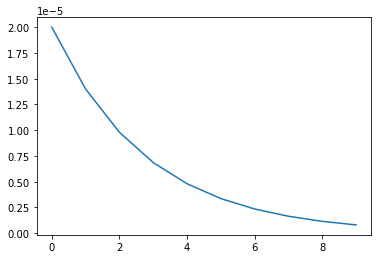

In [15]:
def scheduler(epoch):
    learning_rate = LEARNING_RATE
    if epoch == 0:
        return learning_rate * 1
    else:
        return learning_rate * (0.7**epoch)

plt.plot([scheduler(e) for e in range(EPOCHS)])

Utiliser des **callbacks**  pour améliorer le processus d'entraînement d'un modèle, notamment en sauvegardant le meilleur modèle, en arrêtant précocement l'entraînement si le modèle cesse de s'améliorer, et en ajustant dynamiquement le taux d'apprentissage en fonction des performances. 

In [16]:
# callbacks
model_save = tf.keras.callbacks.ModelCheckpoint(
    f'./model_deberta_fold{fold}.h5', 
    save_best_only = True, 
    save_weights_only = True,
    monitor = 'val_loss', 
    mode = 'min', verbose = 1
)
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    min_delta=1e-5, 
    patience=5, 
    verbose=1,
    mode='auto', 
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=2, 
    mode='auto', 
    min_delta=0.001,
    verbose = 1
)


**** Métriques d’évaluation: F1-score ****

In [17]:

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.f1 = tfa.metrics.F1Score(num_classes=2, average='micro', threshold=0.50)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.reshape(y_true, (-1,MAX_LEN))
        y_pred = tf.reshape(y_pred, (-1,MAX_LEN))
        self.f1.update_state(y_true, y_pred)
        
    def reset_state(self):
        self.f1.reset_state()
    
    def result(self):
        return self.f1.result()
    
metrics = [F1Score()]

**Déterminer le Transformer** à partir  d'un transformeur pré-entraîné en utilisant la bibliothèque TensorFlow et Transformers

In [18]:
# create_model
def create_model() -> tf.keras.Model:
    input_tokens = tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int32)
    attention_mask = tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int32)

    config = AutoConfig.from_pretrained(MODEL_NAME, output_hidden_states=True)
    backbone = TFAutoModel.from_pretrained(MODEL_NAME, config=config)
    #backbone = TFAutoModel.from_pretrained(f'{MODEL_NAME})
    backbone.save_pretrained(f'{MODEL_NAME}/model')

    out = backbone(input_tokens, attention_mask=attention_mask)[0]
    out = tf.keras.layers.Dropout(0.2)(out)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(out)

    return tf.keras.Model(inputs=[input_tokens, attention_mask], outputs=out)

model = create_model()
model.summary()

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE, clipnorm=CLIP_NORM)
loss = tf.keras.losses.BinaryCrossentropy(reduction="none")
model.compile(optimizer=optimizer,loss=loss,metrics=metrics)

Downloading:   0%|          | 0.00/529M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFDebertaModel.

All the layers of TFDebertaModel were initialized from the model checkpoint at microsoft/deberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDebertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_deberta_model (TFDebertaMode TFBaseModelOutput(la 138601728   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 512, 768)     0           tf_deberta_model[0][13]      

## Entrainement

In [23]:
train_data_X =(np.asarray(train_data['input_ids']),np.asarray(train_data['attention_mask']))          
train_data_Y =np.asarray(train_labels)

valid_data = ((np.asarray(val_data['input_ids']),
              np.asarray(val_data['attention_mask']),
             ),np.asarray(val_labels))

In [24]:
xx=np.asarray(train_data['input_ids'])
print(xx.shape)

(11440, 512)


In [24]:
history=model.fit(
            train_data_X,
            train_data_Y, 
            epochs = EPOCHS,
            shuffle=True,
            batch_size = BATCH_SIZE,
            validation_data= valid_data,
            callbacks = [model_save, early_stop, reduce_lr]
)

Epoch 1/10
1430/1430 [==============================] - 1376s 932ms/step - loss: 0.0117 - f1: 0.6735 - val_loss: 0.0060 - val_f1: 0.8277

Epoch 00001: val_loss improved from inf to 0.00604, saving model to ./model_deberta_fold0.h5
Epoch 2/10
1430/1430 [==============================] - 1330s 930ms/step - loss: 0.0056 - f1: 0.8327 - val_loss: 0.0052 - val_f1: 0.8413

Epoch 00002: val_loss improved from 0.00604 to 0.00520, saving model to ./model_deberta_fold0.h5
Epoch 3/10
1430/1430 [==============================] - 1331s 931ms/step - loss: 0.0042 - f1: 0.8717 - val_loss: 0.0058 - val_f1: 0.8483

Epoch 00003: val_loss did not improve from 0.00520

Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 4/10
1430/1430 [==============================] - 1326s 928ms/step - loss: 0.0027 - f1: 0.9156 - val_loss: 0.0056 - val_f1: 0.8615

Epoch 00004: val_loss did not improve from 0.00520
Epoch 5/10
1430/1430 [==============================] - 1326s 928ms/step - 

## **Evaluation de modèle**
### courbe de perte
Une courbe de perte (ou loss curve) montre l'évolution de l'erreur d'un modèle pendant son entraînement. Elle représente généralement la perte sur l'axe vertical (y) et le nombre d'itérations ou d'époques sur l'axe horizontal (x). On y trouve souvent deux courbes : la courbe de perte pour l'entraînement, qui indique comment l'erreur diminue à mesure que le modèle apprend, et la courbe de perte pour la validation, qui montre la performance du modèle sur des données non vues. Cela permet de suivre si le modèle s'améliore ou s'il commence à surapprendre (overfitting).

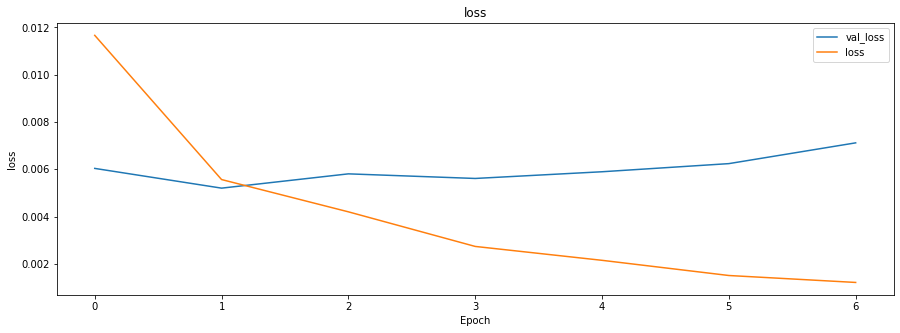

In [25]:
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_loss'],label='val_loss')
plt.plot(range(history.epoch[-1]+1),hi3

**Interprétation des résulttas:** Le modèle apprend bien au départ, comme le montre la diminution de la perte d'entraînement. Cependant, à partir de la troisième époque, la perte de validation commence à augmenter, ce qui suggère que le modèle pourrait surapprendre à partir de ce point. 

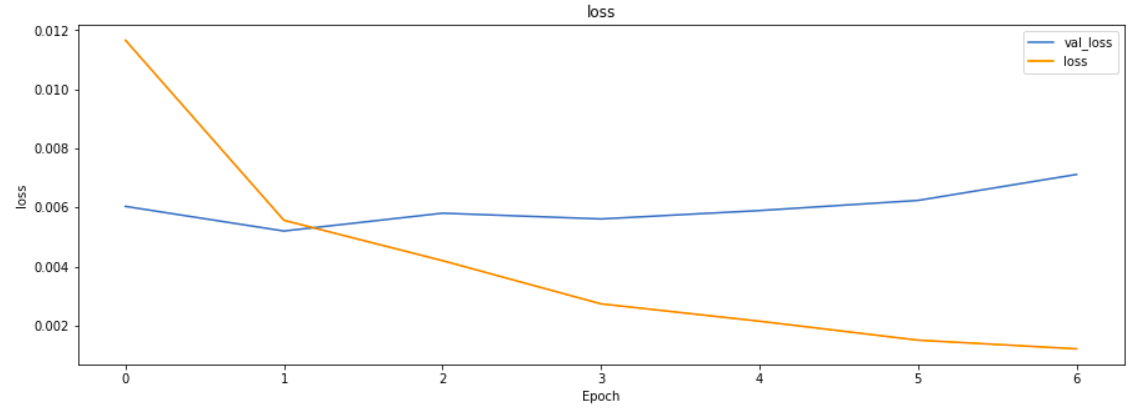

## F1 mesure
Une courbe F1 représente l'évolution de la mesure F1 du modèle proposé au fil des itérations. La mesure F1 combine la précision et le rappel en un seul score, ce qui permet d'évaluer l'équilibre entre les faux positifs et les faux négatifs. Une courbe F1 montre comment cet équilibre évolue au fur et à mesure que le modèle s'ajuste, donnant ainsi un aperçu de ses performances globales. Plus la courbe F1 est élevée et stable, plus la qualité du modèle est élevée.


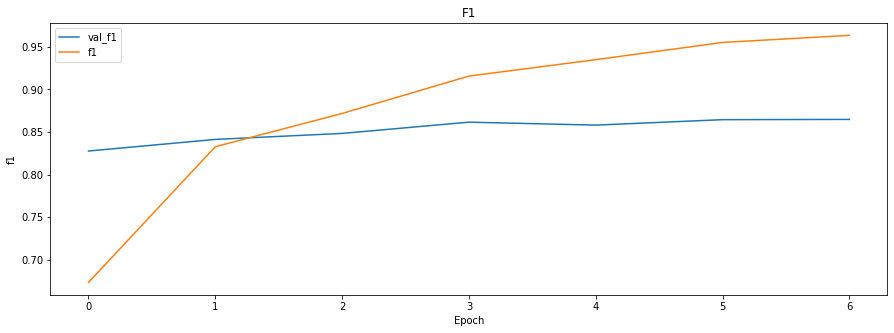

In [26]:
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_f1'],label='val_f1')
plt.plot(range(history.epoch[-1]+1),history.history['f1'],label='f1')
plt.title('F1'); plt.xlabel('Epoch'); plt.ylabel('f1');plt.legend(); 
plt.show()

**Interprétation des résulttas:** les performances du modèle sur les données d'entraînement continuent de s'améliorer, mais sur les données de validation, elles semblent se stabiliser après quelques époques, ce qui suggère qu'il pourrait être judicieux d'arrêter l'entraînement autour de ce moment pour éviter le surapprentissage.
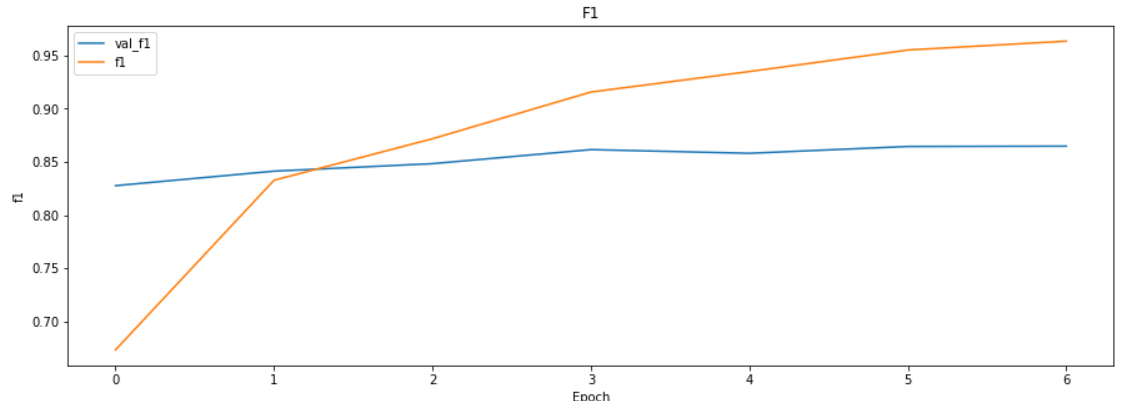